# Node Feature Ranking

Taking all nodes from all graphs (across all mu levels), we split nodes into "stable" (entropy < 0.0195) and "unstable" (entropy >= 0.0195) and use a random forest to determine which node features are most important in the associated binary classification task

In [2]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Reading in the data

Node features have been pre-calculated for each node, as have co-assocation matrices for each graph. The node entropies have to be calculated from the co-association matrices 

In [3]:
X = pd.DataFrame()

for i in [1, 2, 3, 4]:
    for j in [1, 2, 3, 4, 5]:
        features_yml = 'lfr_graphs/mu_0_{0}/graph_0{1}/graph_0{1}_mu_0_{0}_node_features.yml'.format(i, j)
        with open(features_yml) as f:
            feat = yaml.load(f, Loader=yaml.Loader)
        df = pd.DataFrame(feat)
        new_indices = ['graph_{0}_{1}_node_{2}'.format(i, j, k) for k in range(200)]
        df.index = new_indices
        X = pd.concat([X, df])

In [4]:
from scipy.stats import entropy

node_entropies = []

for i in [1, 2, 3, 4]:
    for j in [1, 2, 3, 4, 5]:
        coassociation_yml = 'lfr_graphs/mu_0_{0}/graph_0{1}/graph_0{1}_mu_0_{0}_coassociation.yml'.format(i, j)
        with open(coassociation_yml) as f:
            x = yaml.load(f, Loader=yaml.Loader)
        entropies = entropy(x) / x.shape[0]
        node_entropies += list(entropies)
        
node_entropies = np.array(node_entropies)

The y value is 0 if the node is "stable" and 1 if the node is "unstable".

In [9]:
y = np.where(node_entropies < 0.0195, 0, 1)
y = pd.DataFrame(y, index=X.index, columns=['Stability'])

### Train/Test splitting

First, we split the nodes into train and test sets (80/20). Then we will store the train and test data frames, and ignore the test ones for now.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [45]:
X_train.to_csv('lfr_graphs/node_x_train.csv')
X_test.to_csv('lfr_graphs/node_x_test.csv')
y_train.to_csv('lfr_graphs/node_y_train.csv')
y_test.to_csv('lfr_graphs/node_y_test.csv')

### Feature ranking with random forest

Now we're going to perform the node feature ranking using a random forest. During training, we will use a stratified k-fold cross-validation scheme.

In [71]:
runs = 100

In [72]:
feature_list = list(X_train.columns)
data = np.array(X_train)
labels = np.squeeze(np.array(y_train))

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracy_scores = []
feature_importances = {}
for f in feature_list:
    feature_importances[f] = []
rows = []

skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier()

for run in range(1, runs+1):
    
    for i in range(5):
        folds = next(skf.split(data, labels), None)
        
        X_train_fold = data[folds[0], :]
        X_val_fold = data[folds[1], :]
        y_train_fold = labels[folds[0]]
        y_val_fold = labels[folds[1]]
        
        model = rf.fit(X_train_fold, y_train_fold)
        predictions = rf.predict(X_val_fold)
    
        accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))

    row = { "run" : run }
    for i, feature in enumerate(feature_list):
        row[feature] = rf.feature_importances_[i]
    rows.append(row)

In [74]:
df_importances = pd.DataFrame(rows).set_index("run")

In [75]:
feature_ranking = df_importances.mean().sort_values(ascending=False)

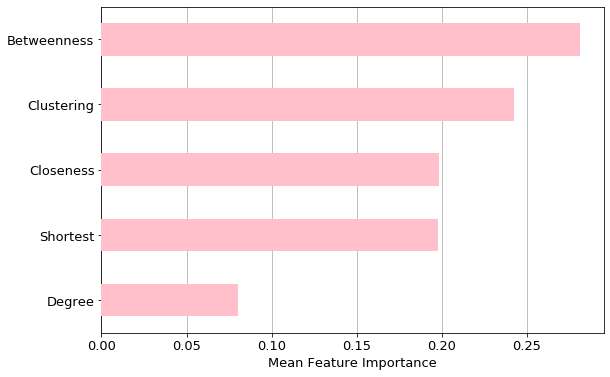

In [76]:
ax = feature_ranking[::-1].plot.barh( fontsize=13, figsize=(9,6), color="pink", zorder=3 );
ax.set_xlabel("Mean Feature Importance", fontsize=13);
ax.xaxis.grid();